<h1><b>Blueberry Yield Prediction

<h2><b>Data

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c playground-series-s3e14

100% 634k/634k [00:00<00:00, 3.24MB/s]
100% 634k/634k [00:00<00:00, 3.24MB/s]


In [2]:
!unzip "/content/playground-series-s3e14.zip" -d "/content/blueberry_yield"

Archive:  /content/playground-series-s3e14.zip
  inflating: /content/blueberry_yield/sample_submission.csv  
  inflating: /content/blueberry_yield/test.csv  
  inflating: /content/blueberry_yield/train.csv  


In [3]:
!kaggle datasets download -d shashwatwork/wild-blueberry-yield-prediction-dataset

  0% 0.00/23.9k [00:00<?, ?B/s]
100% 23.9k/23.9k [00:00<00:00, 27.2MB/s]


In [4]:
!unzip "/content/wild-blueberry-yield-prediction-dataset.zip" -d "/content/blueberry_yield_origin"

Archive:  /content/wild-blueberry-yield-prediction-dataset.zip
  inflating: /content/blueberry_yield_origin/WildBlueberryPollinationSimulationData.csv  


<h2><b>Installation

In [5]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.9 MB/s eta 0:00:00


In [6]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.7 MB/s eta 0:00:00


<h2><b>Imports

In [7]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import copy
import missingno as msno

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate


import os

<h2><b> Reading files

In [8]:
sample_submission = pd.read_csv("/content/blueberry_yield/sample_submission.csv")
origin = pd.read_csv("/content/blueberry_yield_origin/WildBlueberryPollinationSimulationData.csv", index_col = 'Row#')
train = pd.read_csv("/content/blueberry_yield/train.csv", index_col = 'id')
test = pd.read_csv("/content/blueberry_yield/test.csv", index_col = 'id')

In [9]:
no_change_test = pd.read_csv("/content/blueberry_yield/test.csv")

In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      10194 non-null  int64  
 1   yield   10194 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 159.4 KB


In [11]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 0 to 776
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             777 non-null    float64
 1   honeybee              777 non-null    float64
 2   bumbles               777 non-null    float64
 3   andrena               777 non-null    float64
 4   osmia                 777 non-null    float64
 5   MaxOfUpperTRange      777 non-null    float64
 6   MinOfUpperTRange      777 non-null    float64
 7   AverageOfUpperTRange  777 non-null    float64
 8   MaxOfLowerTRange      777 non-null    float64
 9   MinOfLowerTRange      777 non-null    float64
 10  AverageOfLowerTRange  777 non-null    float64
 11  RainingDays           777 non-null    float64
 12  AverageRainingDays    777 non-null    float64
 13  fruitset              777 non-null    float64
 14  fruitmass             777 non-null    float64
 15  seeds                 7

<h2><b> Reference taken from</b></h2><br>
1. https://www.kaggle.com/code/jamjomjim/randomforest-comments-appreciated/notebook<br>
2. https://www.kaggle.com/code/tetsutani/ps3e14-eda-various-models-ensemble-baseline/notebook<br>
3. https://www.geeksforgeeks.org/xgboost-for-regression/<br>
4. https://www.kaggle.com/code/akioonodera/ps-3-14-lgbm-reg#2.-Import-data<br>
5. https://www.kaggle.com/code/mnokno/wild-blueberry-yield-prediction-eda/notebook<br>

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15289 entries, 0 to 15288
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             15289 non-null  float64
 1   honeybee              15289 non-null  float64
 2   bumbles               15289 non-null  float64
 3   andrena               15289 non-null  float64
 4   osmia                 15289 non-null  float64
 5   MaxOfUpperTRange      15289 non-null  float64
 6   MinOfUpperTRange      15289 non-null  float64
 7   AverageOfUpperTRange  15289 non-null  float64
 8   MaxOfLowerTRange      15289 non-null  float64
 9   MinOfLowerTRange      15289 non-null  float64
 10  AverageOfLowerTRange  15289 non-null  float64
 11  RainingDays           15289 non-null  float64
 12  AverageRainingDays    15289 non-null  float64
 13  fruitset              15289 non-null  float64
 14  fruitmass             15289 non-null  float64
 15  seeds              

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10194 entries, 15289 to 25482
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             10194 non-null  float64
 1   honeybee              10194 non-null  float64
 2   bumbles               10194 non-null  float64
 3   andrena               10194 non-null  float64
 4   osmia                 10194 non-null  float64
 5   MaxOfUpperTRange      10194 non-null  float64
 6   MinOfUpperTRange      10194 non-null  float64
 7   AverageOfUpperTRange  10194 non-null  float64
 8   MaxOfLowerTRange      10194 non-null  float64
 9   MinOfLowerTRange      10194 non-null  float64
 10  AverageOfLowerTRange  10194 non-null  float64
 11  RainingDays           10194 non-null  float64
 12  AverageRainingDays    10194 non-null  float64
 13  fruitset              10194 non-null  float64
 14  fruitmass             10194 non-null  float64
 15  seeds          

<h2><b> Preprocessing

In [14]:
origin.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)
train.reset_index(drop = True, inplace = True)

In [15]:
col_id = []
for i in range(len(origin)):
    col_id.append(i+25484)

In [16]:
data_t_o = pd.concat([train, origin], ignore_index = True)
data_t_o = data_t_o.drop_duplicates()
data_all = pd.concat([data_t_o, test], ignore_index = True)
data_all

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26248,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.474162,0.437923,34.525258,NaN
26249,25.0,0.50,0.25,0.50,0.75,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.482854,0.440676,35.648221,NaN
26250,25.0,0.50,0.38,0.50,0.50,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.568854,0.463065,37.724724,NaN
26251,12.5,0.25,0.25,0.38,0.50,94.6,57.2,79.0,68.2,33.0,55.9,34.0,0.56,0.407374,0.409261,31.881847,NaN


<h2><b> EDA

<Axes: >

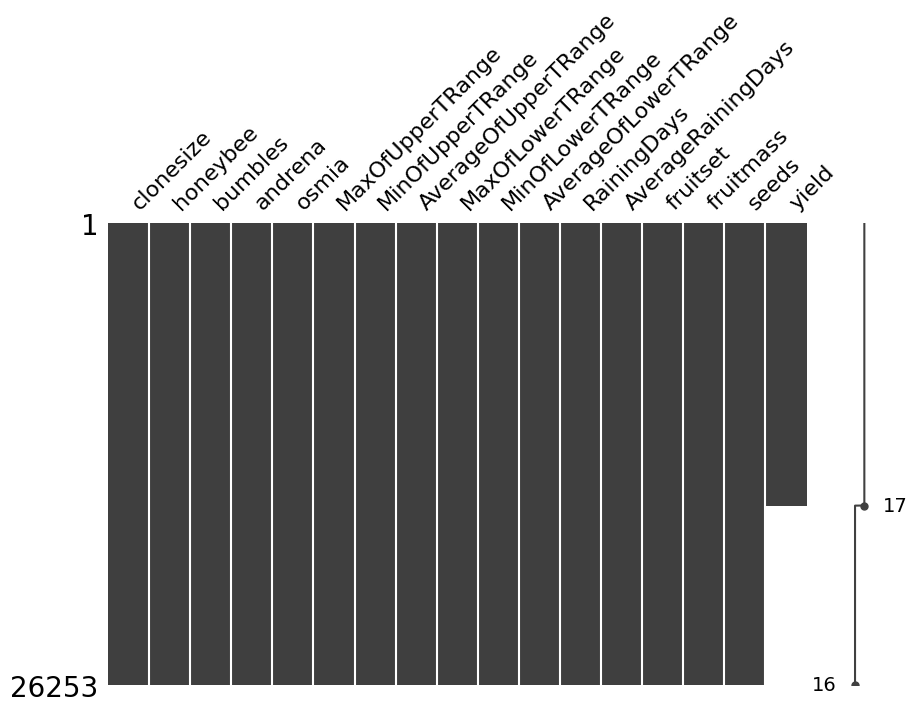

In [17]:
msno.matrix(df = data_all, figsize=(10,6))

<Axes: >

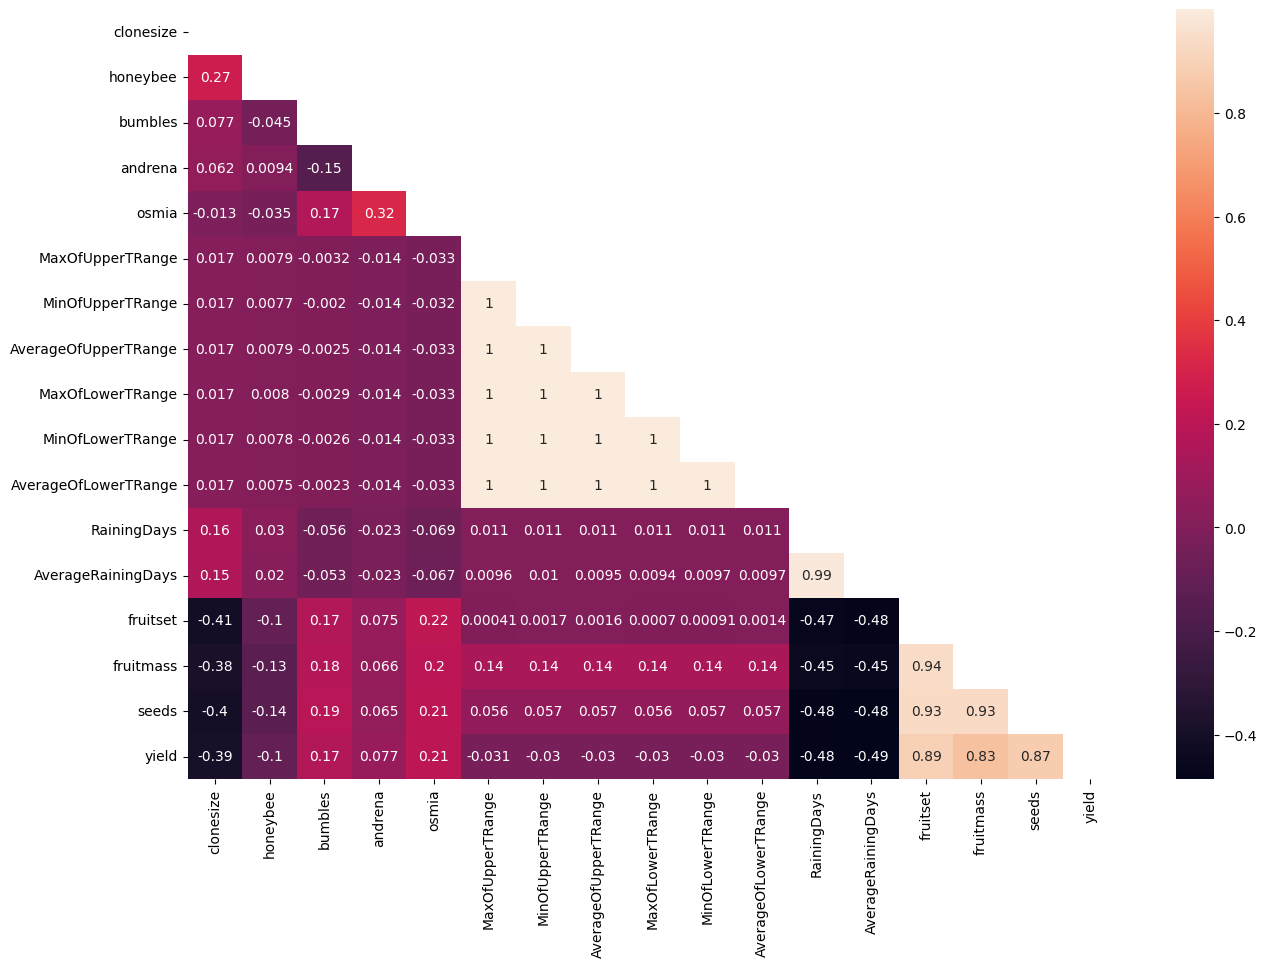

In [18]:
plt.figure(figsize = (15, 10))
corr_matrix = data_t_o.corr()
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, annot = True, mask = mask)

In [19]:
data_train = data_t_o.copy()
# to_drop = ['MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'RainingDays']
# data_train.drop(to_drop, axis = 1, inplace = True)
data_train.columns

Index(['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

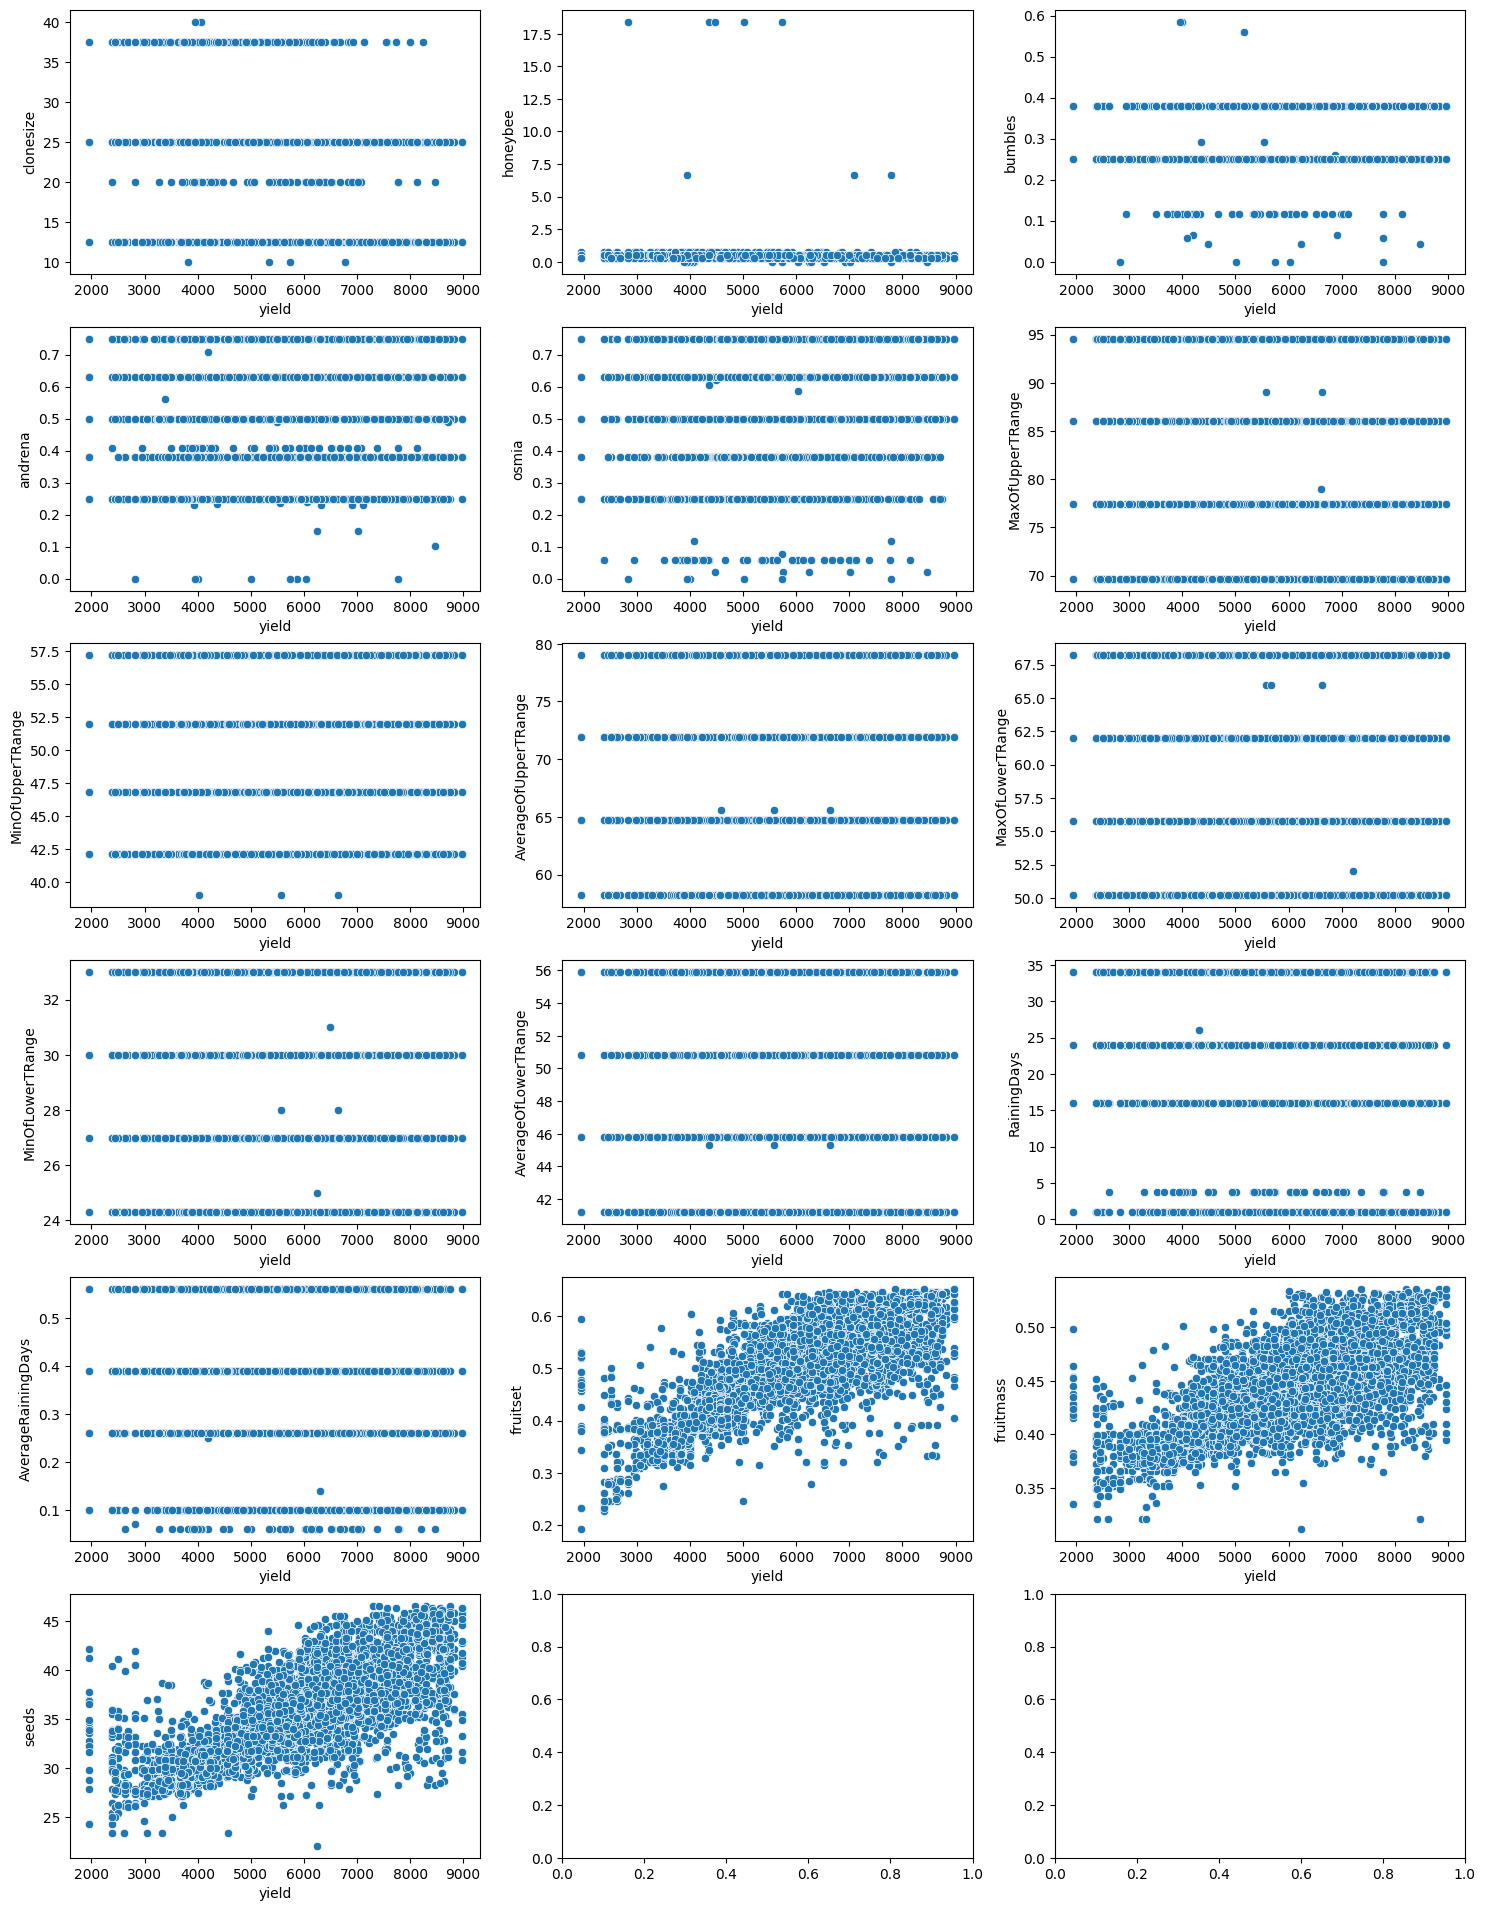

In [20]:
features = data_train.columns.tolist()
features.remove("yield")
n_rows = len(features)//3 + 1
fig, axes = plt.subplots(nrows = n_rows, ncols = 3, figsize = (18, 4*n_rows))
axes = axes.flatten()
for i, col in enumerate(features):
    ax = axes[i]
    sns.scatterplot(x = train["yield"], y = train[col], ax = ax)

In [21]:
print("Column: \t\t Unique values")
for i, col in enumerate(features):
    print(col, ": \t\t", len(data_train[col].unique()))
print("yield", ": \t\t", len(data_train["yield"].unique()))

Column: 		 Unique values
clonesize : 		 6
honeybee : 		 7
bumbles : 		 12
andrena : 		 17
osmia : 		 16
MaxOfUpperTRange : 		 6
MinOfUpperTRange : 		 5
AverageOfUpperTRange : 		 5
MaxOfLowerTRange : 		 6
MinOfLowerTRange : 		 7
AverageOfLowerTRange : 		 5
RainingDays : 		 6
AverageRainingDays : 		 8
fruitset : 		 1526
fruitmass : 		 1515
seeds : 		 2067
yield : 		 1470


In [22]:
print("Number of rows in train data:", len(train))
print("Unique yield value in train data:", len(train["yield"].unique()))
print()
print("Number of rows in origin data:", len(origin))
print("Unique yield value in origin data:", len(origin["yield"].unique()))
print()
print("Number of rows in cumulative train data:", len(data_train))
print("Unique yield value in cumulative train data:", len(data_train["yield"].unique()))

Number of rows in train data: 15289
Unique yield value in train data: 776

Number of rows in origin data: 777
Unique yield value in origin data: 777

Number of rows in cumulative train data: 16059
Unique yield value in cumulative train data: 1470


* After adding 777 rows from origin data to 15289 rows of train data the number of unique value of yield is increased from 776 to 1470 which is increment of 694 unique values
* This shows that adding origin data to train data is adding more disturbance compared to additional data provided by it
* This observation give us a reason to not add origin data to our initial train data

In [23]:
final_train = train.copy()
# final_train.drop(to_drop, axis = 1, inplace = True)
final_train.columns

Index(['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

In [24]:
final_test = test.copy()
# final_test.drop(to_drop, axis = 1, inplace = True)
final_test.columns

Index(['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds'],
      dtype='object')

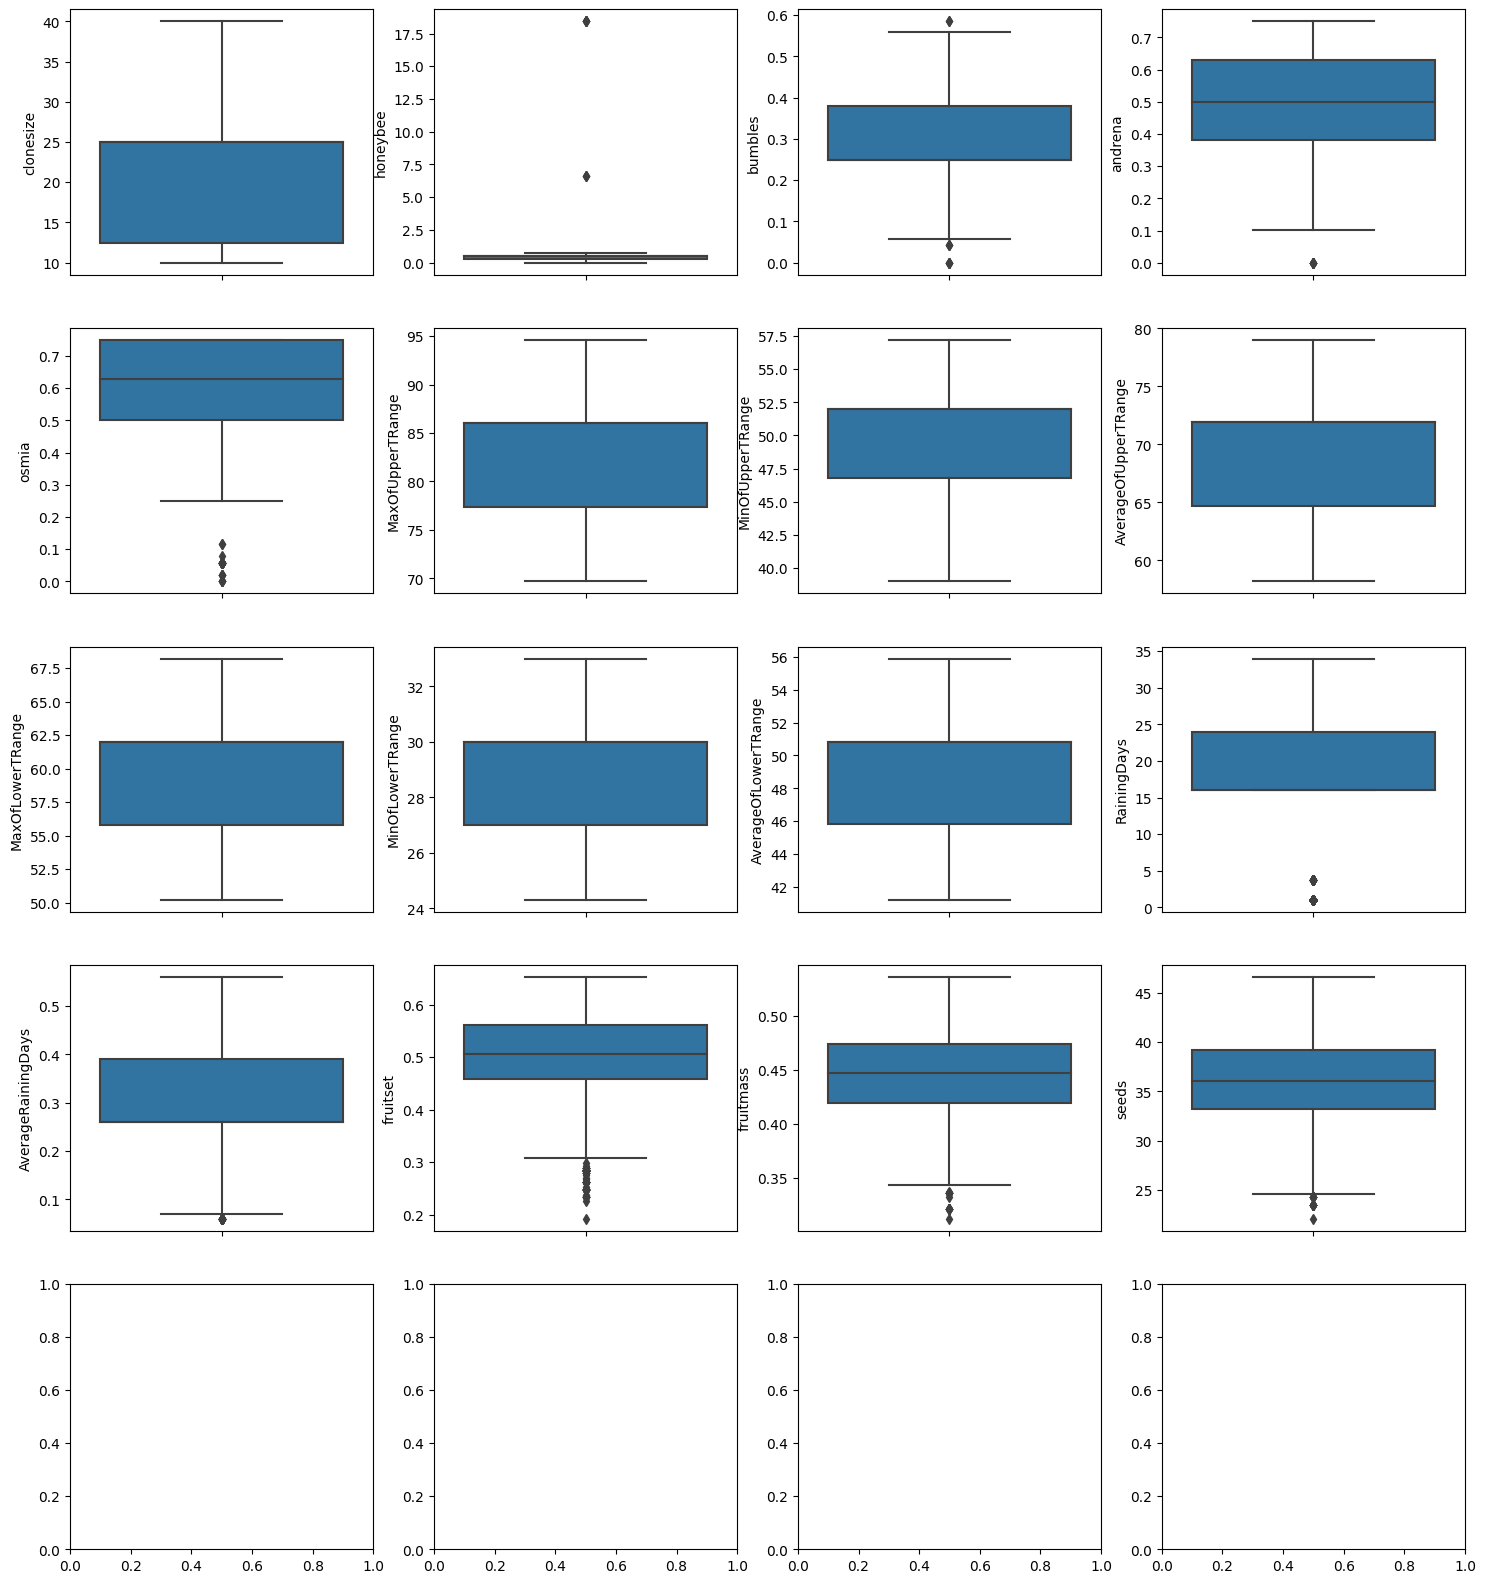

In [25]:
features_2 = final_train.columns.tolist()
features_2.remove('yield')

n_rows = len(features_2)//4 + 1

fig, axes = plt.subplots(nrows = n_rows, ncols = 4, figsize = (18, 4*n_rows))
axes = axes.flatten()

i = 0
for col in features_2:
    ax = axes[i]
    sns.boxplot(data = final_train, y = col, ax = ax)
    i += 1
# sns.boxplot(data = final_test, y = "yield", ax = axes[i])

* Some of the above boxplots has no median line, this is because the median in those cases are same as 25 or 75 quantile.
* Always remember median is always equal to 50 quantile

In [26]:
def outlayer_data(data: pd.DataFrame, col: str) -> pd.DataFrame:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    outlayer = data[(data[col]<lower_bound)|(data[col]>upper_bound)][[col]]
    return outlayer

In [27]:
print("Column: \t\t Number of outlayers")
for col in features:
    print(col, ": \t\t", len(outlayer_data(final_train, col)))

Column: 		 Number of outlayers
clonesize : 		 0
honeybee : 		 8
bumbles : 		 10
andrena : 		 8
osmia : 		 56
MaxOfUpperTRange : 		 0
MinOfUpperTRange : 		 0
AverageOfUpperTRange : 		 0
MaxOfLowerTRange : 		 0
MinOfLowerTRange : 		 0
AverageOfLowerTRange : 		 0
RainingDays : 		 3569
AverageRainingDays : 		 49
fruitset : 		 97
fruitmass : 		 23
seeds : 		 24


In [28]:
outlayer_data(final_train, "RainingDays")["RainingDays"].unique()

array([1.  , 3.77])

In [29]:
final_train['RainingDays'].unique()

array([24.  , 34.  ,  1.  , 16.  ,  3.77, 26.  ])

In [30]:
final_copy = final_train.copy()

In [31]:
def remove_outlayer(data: pd.DataFrame, col: str):
    for i in range(len(outlayer_data(data, col)[col].unique())):
        out_layer_data = outlayer_data(data, col)[col].unique()
        out = outlayer_data(data, col)[col].unique()[0] if (len(out_layer_data) > 0) else None
        if out == None:
            continue
        index = data[data[col]==out].index.tolist()
        data.drop(index, inplace = True)
    print("Outlayers are successfully removed!!")

In [32]:
for i, col in enumerate(features_2):
    print(col)
    remove_outlayer(final_copy, col)

clonesize
Outlayers are successfully removed!!
honeybee
Outlayers are successfully removed!!
bumbles
Outlayers are successfully removed!!
andrena
Outlayers are successfully removed!!
osmia
Outlayers are successfully removed!!
MaxOfUpperTRange
Outlayers are successfully removed!!
MinOfUpperTRange
Outlayers are successfully removed!!
AverageOfUpperTRange
Outlayers are successfully removed!!
MaxOfLowerTRange
Outlayers are successfully removed!!
MinOfLowerTRange
Outlayers are successfully removed!!
AverageOfLowerTRange
Outlayers are successfully removed!!
RainingDays
Outlayers are successfully removed!!
AverageRainingDays
Outlayers are successfully removed!!
fruitset
Outlayers are successfully removed!!
fruitmass
Outlayers are successfully removed!!
seeds
Outlayers are successfully removed!!


In [33]:
print("Column : \t\t mean_no_outlayer \t mean_outlayer \t change")
for i, col in enumerate(features_2):
    change = round(((final_train[col].mean()-final_copy[col].mean())/final_train[col].mean())*100, 4)
    print(col, " : \t\t ", round(final_train[col].mean(),4)," \t\t ", round(final_copy[col].mean(), 4)," \t ", change, "%", sep = "")

Column : 		 mean_no_outlayer 	 mean_outlayer 	 change
clonesize : 		 19.7047 		 20.1254 	 -2.135%
honeybee : 		 0.3893 		 0.3905 	 -0.3117%
bumbles : 		 0.2868 		 0.2857 	 0.37%
andrena : 		 0.4927 		 0.4932 	 -0.108%
osmia : 		 0.5924 		 0.5916 	 0.1277%
MaxOfUpperTRange : 		 82.1699 		 82.196 	 -0.0318%
MinOfUpperTRange : 		 49.6733 		 49.6899 	 -0.0335%
AverageOfUpperTRange : 		 68.6563 		 68.6779 	 -0.0316%
MaxOfLowerTRange : 		 59.2295 		 59.2495 	 -0.0337%
MinOfLowerTRange : 		 28.6606 		 28.67 	 -0.0329%
AverageOfLowerTRange : 		 48.5685 		 48.5841 	 -0.032%
RainingDays : 		 18.6609 		 23.9587 	 -28.39%
AverageRainingDays : 		 0.3242 		 0.3915 	 -20.7762%
fruitset : 		 0.5027 		 0.4911 	 2.308%
fruitmass : 		 0.4466 		 0.4407 	 1.3043%
seeds : 		 36.165 		 35.4623 	 1.9428%


* No much change in mean after removing outlayers.
* Therefore we will not remove outlayer from our training data as data loss also takes place with removal of outlayer
* We will continue with final_train dataset

<h2><b> Feature Engineering

In [34]:
final_train['Pollinators'] = final_train['honeybee'] + final_train['bumbles'] + final_train['andrena'] + final_train['osmia']
final_test['Pollinators'] = final_test['honeybee'] + final_test['bumbles'] + final_test['andrena'] + final_test['osmia']
features_2.append("Pollinators")

In [35]:
outlayer_data(final_train, "Pollinators").shape

(691, 1)

In [36]:
final_copy = final_train.copy()
remove_outlayer(final_copy, "Pollinators")

Outlayers are successfully removed!!


In [37]:
change = (final_train['Pollinators'].mean()-final_copy['Pollinators'].mean())/final_train['Pollinators'].mean() * 100
print("Percent change after outlayer removal : \t",round(change, 2),"%",sep = "")

Percent change after outlayer removal : 	-1.65%


* Same observation as above, hence not going to remove outlayers

In [38]:
print("Column: \t\t Unique values")
for i, col in enumerate(features_2):
    print(col, ": \t\t", len(final_train[col].unique()))
print("yield", ": \t\t", len(final_train["yield"].unique()))

Column: 		 Unique values
clonesize : 		 6
honeybee : 		 7
bumbles : 		 11
andrena : 		 16
osmia : 		 14
MaxOfUpperTRange : 		 6
MinOfUpperTRange : 		 5
AverageOfUpperTRange : 		 5
MaxOfLowerTRange : 		 6
MinOfLowerTRange : 		 7
AverageOfLowerTRange : 		 5
RainingDays : 		 6
AverageRainingDays : 		 8
fruitset : 		 1526
fruitmass : 		 1515
seeds : 		 2066
Pollinators : 		 60
yield : 		 776


In [39]:
print("Column: \t\t Unique values")
for i, col in enumerate(features):
    print(col, ": \t\t", len(test[col].unique()))
# print("yield", ": \t\t", len(data_train["yield"].unique()))

Column: 		 Unique values
clonesize : 		 5
honeybee : 		 7
bumbles : 		 8
andrena : 		 12
osmia : 		 14
MaxOfUpperTRange : 		 7
MinOfUpperTRange : 		 6
AverageOfUpperTRange : 		 6
MaxOfLowerTRange : 		 5
MinOfLowerTRange : 		 5
AverageOfLowerTRange : 		 5
RainingDays : 		 6
AverageRainingDays : 		 5
fruitset : 		 1209
fruitmass : 		 1299
seeds : 		 1643


In [40]:
print("origin : \t", sorted(origin["AverageOfLowerTRange"].unique()))
print("final_train : \t", sorted(final_train["AverageOfLowerTRange"].unique()))
print("test : \t", sorted(test["AverageOfLowerTRange"].unique()))

origin : 	 [41.2, 45.3, 45.8, 50.8, 55.9]
final_train : 	 [41.2, 45.3, 45.8, 50.8, 55.9]
test : 	 [41.2, 45.3, 45.8, 50.8, 55.9]


* AverageOfLowerTRange can be assumed to be a categorical data

In [41]:
print("origin : \t", sorted(origin["AverageRainingDays"].unique()))
print("final_train : \t", sorted(final_train["AverageRainingDays"].unique()))
print("test : \t", sorted(test["AverageRainingDays"].unique()))

origin : 	 [0.06, 0.1, 0.26, 0.39, 0.56]
final_train : 	 [0.06, 0.07, 0.1, 0.14, 0.25, 0.26, 0.39, 0.56]
test : 	 [0.06, 0.1, 0.26, 0.39, 0.56]


In [42]:
# AverageRainingDays_diff = [0.07, 0.14, 0.25]
AverageRainingDays_diff = [0.06, 0.07, 0.1, 0.14, 0.25, 0.26, 0.39, 0.56]
for i, val in enumerate(AverageRainingDays_diff):
    print(val, ":\t", len(final_train[final_train['AverageRainingDays']==val]))

0.06 :	 49
0.07 :	 1
0.1 :	 3520
0.14 :	 1
0.25 :	 1
0.26 :	 4361
0.39 :	 3837
0.56 :	 3519


* There are only 3 rows in total(one for each of non unique value in final_train and test) in final_train dataset.
* If we remove these 3 rows then we can treat AverageRainingDays column as categorical column.

In [43]:
final_train.drop(final_train[final_train['AverageRainingDays']==0.07].index[0], inplace = True)
final_train.drop(final_train[final_train['AverageRainingDays']==0.14].index[0], inplace = True)
final_train.drop(final_train[final_train['AverageRainingDays']==0.25].index[0], inplace = True)

In [44]:
print("origin : \t", sorted(origin["clonesize"].unique()))
print("final_train : \t", sorted(final_train["clonesize"].unique()))
print("test : \t", sorted(test["clonesize"].unique()))

origin : 	 [10.0, 12.5, 20.0, 25.0, 37.5, 40.0]
final_train : 	 [10.0, 12.5, 20.0, 25.0, 37.5, 40.0]
test : 	 [10.0, 12.5, 20.0, 25.0, 37.5]


In [45]:
# AverageRainingDays_diff = [0.07, 0.14, 0.25]
AverageRainingDays_diff = [10.0, 12.5, 20.0, 25.0, 37.5, 40.0]
for i, val in enumerate(AverageRainingDays_diff):
    print(val, ":\t", len(final_train[final_train['clonesize']==val]))

10.0 :	 4
12.5 :	 6717
20.0 :	 55
25.0 :	 8243
37.5 :	 265
40.0 :	 2


In [46]:
final_train["fruit_seed"] = final_train["fruitset"] * final_train["seeds"]
final_test["fruit_seed"] = final_test["fruitset"] * final_test["seeds"]

In [47]:
final_train['Temp'] = (final_train['AverageOfLowerTRange']+final_train['AverageOfUpperTRange'])/2
final_test['Temp'] = (final_test['AverageOfLowerTRange']+final_test['AverageOfUpperTRange'])/2
final_train.head(3)

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield,Pollinators,fruit_seed,Temp
0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146,2.00,13.796231,49.70
1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201,1.75,15.063846,49.70
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760,1.76,21.200199,61.35


In [48]:
features_2.append("fruit_seed")
features_2.append("Temp")

In [49]:
len(outlayer_data(final_train, "fruit_seed"))

0

<h2><b> Feature Selection

Trying **wrapper method** to select feature

In [50]:
train.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


In [51]:
final_test.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,Pollinators,fruit_seed,Temp
0,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.399367,0.408088,31.394569,1.00,12.537955,61.35
1,12.5,0.25,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.488048,0.442866,36.846956,1.88,17.983080,67.45
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.583379,0.487057,40.037644,1.76,23.357110,61.35
3,25.0,0.50,0.38,0.38,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.433014,0.422847,33.116091,1.89,14.339741,61.35
4,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.360996,0.388860,29.558019,1.50,10.670317,67.45


In [52]:
X = final_train.drop("yield", axis = 1)
y = final_train["yield"]
model_scalar = StandardScaler()
scaled_X = model_scalar.fit_transform(X)
X = pd.DataFrame(scaled_X, columns = X.columns)
X.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,Pollinators,fruit_seed,Temp
0,0.802992,0.338089,-0.614473,1.737740,-0.662761,-1.363370,-1.365488,-1.368344,-1.365958,-1.364698,-1.366977,0.458047,0.401418,-1.045450,-0.783596,-0.919210,0.579387,-1.016508,-1.367787
1,0.802992,0.338089,-0.614473,0.049314,-0.662761,-1.363370,-1.365488,-1.368344,-1.365958,-1.364698,-1.366977,0.458047,0.401418,-0.777900,-0.661907,-0.572495,-0.024158,-0.740300,-1.367787
2,-1.092279,-0.417381,-0.614473,0.927296,0.269717,0.418624,0.419382,0.424355,0.418973,0.419066,0.413848,0.458047,0.401418,0.674572,0.656028,0.539893,-0.000016,0.596789,0.420012
3,-1.092279,-0.417381,-0.614473,0.927296,-0.662761,-0.521569,-0.518125,-0.517793,-0.518872,-0.519757,-0.513665,0.458047,0.401418,0.850045,0.852731,0.819209,-0.313860,0.844648,-0.516089
4,0.802992,0.338089,-0.614473,0.927296,0.269717,-0.521569,-0.518125,-0.517793,-0.518872,-0.519757,-0.513665,0.458047,0.401418,1.034264,1.285590,1.071524,0.603529,1.090917,-0.516089


In [53]:
scaled_test = model_scalar.transform(final_test)
final_test = pd.DataFrame(scaled_test, columns = final_test.columns)

In [54]:
final_test.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,Pollinators,fruit_seed,Temp
0,0.802992,-0.417381,-0.614473,-1.639111,-2.455987,0.418624,0.419382,0.424355,0.418973,0.419066,0.413848,0.458047,0.401418,-1.390271,-1.039002,-1.183774,-1.834793,-1.290682,0.420012
1,-1.092279,-0.417381,-0.614473,1.737740,0.269717,1.358817,1.356890,1.353418,1.356819,1.357889,1.359912,-1.515062,-1.368010,-0.197822,-0.099798,0.169013,0.289685,-0.104209,1.356113
2,-1.092279,-0.417381,-0.614473,0.927296,0.269717,0.418624,0.419382,0.424355,0.418973,0.419066,0.413848,-0.228252,-0.391774,1.084044,1.093632,0.960652,-0.000016,1.066771,0.420012
3,0.802992,0.338089,1.556737,-0.761130,0.269717,0.418624,0.419382,0.424355,0.418973,0.419066,0.413848,-0.228252,-0.391774,-0.937832,-0.640432,-0.756648,0.313827,-0.898079,0.420012
4,2.698262,1.093559,-0.614473,-1.639111,-2.455987,1.358817,1.356890,1.353418,1.356819,1.357889,1.359912,0.458047,0.401418,-1.906231,-1.558268,-1.639438,-0.627703,-1.697633,1.356113


<h2><b>Train Test Split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [56]:
X_cv = X.copy()
y_cv = y.copy()

In [57]:
def cross_validation(model, X, y, cv = 5):
    scoring = ['neg_mean_absolute_error', 'accuracy']
    results = cross_validate(estimator = model, X = X, y = y, cv = cv, scoring = scoring, return_train_score=True)
    return {"Training neg_mean_absolute_error scores": results['train_neg_mean_absolute_error'],
              "Mean Training neg_mean_absolute_error": results['train_neg_mean_absolute_error'].mean(),
              "Validation neg_mean_absolute_error scores": results['test_neg_mean_absolute_error'],
              "Mean Validation neg_mean_absolute_error": results['test_neg_mean_absolute_error'].mean(),
              }

<h2><b>Modeling

<h3><b> XGBoost

* Trying top 6 features for our model training

In [60]:
col = ['fruitset', 'fruit_seed', 'seeds', 'fruitmass', 'honeybee', 'andrena', 'bumbles', 'osmia', 'AverageRainingDays', 'Temp']

In [62]:
X_cv_final_xgb = X_cv[col]

In [63]:
xgb_model = xgb.XGBRegressor(booster = 'gbtree',
                         objective = 'reg:squarederror',
                         eval_metric = 'mae',
#                          tree_method = 'gpu_hist',
                         n_estimators = 63,
                         learning_rate = 0.093,
                         max_depth = 6,
                         min_child_weight = 14,
                         random_state = 108)

In [65]:
%%time
xgb_result = cross_validation(xgb_model, X_cv_final_xgb, y_cv, 10)
print(xgb_result)

{'Training neg_mean_absolute_error scores': array([-325.60928463, -326.37914216, -325.93935849, -326.54425353,
       -327.94453653, -326.21961399, -326.29777905, -325.41042764,
       -326.45160533, -327.13105079]), 'Mean Training neg_mean_absolute_error': -326.39270521301603, 'Validation neg_mean_absolute_error scores': array([-361.04749277, -348.34080541, -361.07237262, -348.66521941,
       -342.45327175, -360.07951633, -349.10530416, -344.38619378,
       -361.33052933, -345.68133013]), 'Mean Validation neg_mean_absolute_error': -352.2162035693122}
CPU times: user 17.6 s, sys: 97 ms, total: 17.7 s
Wall time: 10.2 s


In [66]:
X_train_xgb = X_train[col]
X_test_xgb = X_test[col]

In [67]:
xgb_model.fit(X_train_xgb, y_train)
Predict_xgb = xgb_model.predict(X_test_xgb)
mae(y_test, Predict_xgb)

361.606520266514

In [68]:
Predict_train_xgb = xgb_model.predict(X_train_xgb)
mae(y_train, Predict_train_xgb)

323.0606021247917

In [69]:
X_final_xgb = X[col]
final_test_xgb = final_test[col]
xgb_model.fit(X_final_xgb, y)
Predict_final_xgb = xgb_model.predict(final_test_xgb)

<h3><b> LightGBM

In [74]:
col = ['fruit_seed', 'fruitset', 'seeds', 'fruitmass', 'honeybee', 'Pollinators', 'AverageRainingDays', 'Temp']

In [76]:
X_cv_final_lgb = X_cv[col]

In [78]:
# lgb_params = {
#             'n_estimators': 100,
#             #'max_depth': 6,
#             "num_leaves": 16,
#             'learning_rate': 0.05,
#             'subsample': 0.60,
#             'colsample_bytree': 1,
#             #'reg_alpha': 0.25,
#             'reg_lambda': 5e-07,
#             'objective': 'regression_l1',
#             'metric': 'mean_absolute_error',
#             'boosting_type': 'gbdt',
#             'device': 'cpu',
#             'random_state': 108
#         }
lgb2_params = {
            'n_estimators': 100,
            'num_leaves': 93,
            'min_child_samples': 20,
            'learning_rate': 0.05533790147941807,
            'colsample_bytree': 0.8809128870084636,
            'reg_alpha': 0.0009765625,
            'reg_lambda': 0.015589408048174165,
            'objective': 'regression_l1',
            'metric': 'mean_absolute_error',
            'boosting_type': 'gbdt',
            'device': "cpu",
            'random_state': 108
        }
# lgb3_params = {
#             'n_estimators': 100,
#             #'num_leaves': 45,
#             'max_depth': 13,
#             'learning_rate': 0.0684383311038932,
#             'subsample': 0.5758412171285148,
#             'colsample_bytree': 0.8599714680300794,
#             'reg_lambda': 1.597717830931487e-08,
#             'objective': 'regression_l1',
#             'metric': 'mean_absolute_error',
#             'boosting_type': 'gbdt',
#             'device': "cpu",
#             'random_state': 108,
#             'force_col_wise': True
# }
# lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb2_model = lgb.LGBMRegressor(**lgb2_params)
# lgb3_model = lgb.LGBMRegressor(**lgb3_params)

In [79]:
%%time
# lgb_result = cross_validation(lgb_model, X_cv_final_lgb, y_cv, 10)
lgb2_result = cross_validation(lgb2_model, X_cv_final_lgb, y_cv, 10)
# lgb3_result = cross_validation(lgb3_model, X_cv_final_lgb, y_cv, 10)

# 352.03076504430084

CPU times: user 10.7 s, sys: 143 ms, total: 10.9 s
Wall time: 8.83 s


In [80]:
# print("Mean Validation neg_mean_absolute_error:", lgb_result['Mean Validation neg_mean_absolute_error'], '\nMean Training neg_mean_absolute_error:', lgb_result['Mean Training neg_mean_absolute_error'], "\n")
print("Mean Validation neg_mean_absolute_error:", lgb2_result['Mean Validation neg_mean_absolute_error'], '\nMean Training neg_mean_absolute_error:', lgb2_result['Mean Training neg_mean_absolute_error'], "\n")
# print("Mean Validation neg_mean_absolute_error:", lgb3_result['Mean Validation neg_mean_absolute_error'], '\nMean Training neg_mean_absolute_error:', lgb3_result['Mean Training neg_mean_absolute_error'])

Mean Validation neg_mean_absolute_error: -342.6344825381924 
Mean Training neg_mean_absolute_error: -306.4240475615896 



In [81]:
X_train_lgb = X_train[col]
X_test_lgb = X_test[col]

In [82]:
lgb2_model.fit(X_train_lgb, y_train)
Predict_lgb = lgb2_model.predict(X_test_lgb)
mae(y_test, Predict_lgb)

352.2555882596871

In [83]:
Predict_train_lgb = lgb2_model.predict(X_train_lgb)
mae(y_train, Predict_train_lgb)

302.18896962915335

In [84]:
X_final_lgb = X[col]
final_test_lgb = final_test[col]
lgb2_model.fit(X_final_lgb, y)
Predict_final_lgb = lgb2_model.predict(final_test_lgb)

<h3><b>CatBoost

In [89]:
col = X_train.columns.tolist()

In [91]:
X_cv_final_cb = X_cv[col]

In [94]:
# cb_params = {
#     'iterations': 100,
#     'depth': 8,
#     'learning_rate': 0.01,
#     'l2_leaf_reg': 0.7,
#     'random_strength': 0.2,
#     'max_bin': 200,
#     'od_wait': 65,
#     'one_hot_max_size': 70,
#     'grow_policy': 'Depthwise',
#     'bootstrap_type': 'Bayesian',
#     'od_type': 'Iter',
#     'eval_metric': 'MAE',
#     'loss_function': 'MAE',
#     'task_type': "CPU",
#     'random_state': 108,
#     "verbose" : False
# }
# cb2_params = {
#     'iterations': 100,
#     'depth': 9,
#     'learning_rate': 0.456,
#     'l2_leaf_reg': 8.41,
#     'random_strength': 0.18,
#     'max_bin': 225,
#     'od_wait': 58,
#     'grow_policy': 'Lossguide',
#     'bootstrap_type': 'Bayesian',
#     'od_type': 'Iter',
#     'eval_metric': 'MAE',
#     'loss_function': 'MAE',
#     'task_type': "CPU",
#     'random_state': 108,
#     "verbose" : False
# }
cb3_params = {
    'n_estimators': 100,
    'depth': 10,
    'learning_rate': 0.08827842054729117,
    'l2_leaf_reg': 4.8351074756668864e-05,
    'random_strength': 0.21306687539993183,
    'max_bin': 483,
    'od_wait': 97,
    'grow_policy': 'Lossguide',
    'bootstrap_type': 'Bayesian',
    'od_type': 'Iter',
    'eval_metric': 'MAE',
    'loss_function': 'MAE',
    'task_type': "CPU",
    'random_state': 108,
    'silent': True
}

# cb_model = cb.CatBoostRegressor(**cb_params)
# cb2_model = cb.CatBoostRegressor(**cb2_params)
cb3_model = cb.CatBoostRegressor(**cb3_params)

In [95]:
%%time
# cb_result = cross_validation(cb_model, X_cv_final_cb, y_cv, 10)
# cb2_result = cross_validation(cb2_model, X_cv_final_cb, y_cv, 10)
cb3_result = cross_validation(cb3_model, X_cv_final_cb, y_cv, 10)
# -343.0231413460474

CPU times: user 32.6 s, sys: 1.27 s, total: 33.9 s
Wall time: 20.6 s


In [96]:
# print("Mean Validation neg_mean_absolute_error:", cb_result['Mean Validation neg_mean_absolute_error'], '\nMean Training neg_mean_absolute_error:', cb_result['Mean Training neg_mean_absolute_error'], "\n")
# print("Mean Validation neg_mean_absolute_error:", cb2_result['Mean Validation neg_mean_absolute_error'], '\nMean Training neg_mean_absolute_error:', cb2_result['Mean Training neg_mean_absolute_error'], "\n")
print("Mean Validation neg_mean_absolute_error:", cb3_result['Mean Validation neg_mean_absolute_error'], '\nMean Training neg_mean_absolute_error:', cb3_result['Mean Training neg_mean_absolute_error'], "\n")

Mean Validation neg_mean_absolute_error: -343.5201545633672 
Mean Training neg_mean_absolute_error: -324.7978824713146 



In [97]:
X_train_cb = X_train[col]
X_test_cb = X_test[col]

In [98]:
cb3_model.fit(X_train_cb, y_train)
Predict_cb = cb3_model.predict(X_test_cb)
mae(y_test, Predict_cb)

355.28315433233587

In [99]:
Predict_train_cb = cb3_model.predict(X_train_cb)
mae(y_train, Predict_train_cb)

321.3333567908604

In [100]:
X_final_cb = X[col]
final_test_cb = final_test[col]
cb3_model.fit(X_final_cb, y)
Predict_final_cb = cb3_model.predict(final_test_cb)

<h3><b> XGB + LightGBM + CatBoost

In [101]:
mae(y_test, Predict_lgb)

352.2555882596871

In [102]:
mae(y_test, Predict_xgb)

361.606520266514

In [103]:
Predict_xlc = (Predict_xgb + Predict_lgb + Predict_cb)/3
mae(y_test, Predict_xlc)

352.86917665601294

In [104]:
# Using Optuna to get weights

import optuna


def coef_objective(trial):
    a = trial.suggest_float('a', -1, 1)
    b = trial.suggest_float('b', -1, 1)
    c = trial.suggest_float('c', -1, 1)

    Predict_xlc_optuna =  (Predict_xgb * a + Predict_lgb * b + Predict_cb * c)/(a + b + c)
#     Predict_xlc_optuna =  (Predict_lgb * b + Predict_cb * c)/(b + c)

    mae_score = mae(y_test,Predict_xlc_optuna)


    return mae_score

study = optuna.create_study(direction = 'minimize')
# find the optimum coefficients a, b and c

study.optimize(coef_objective, n_trials= 800)

[I 2023-07-11 15:50:25,198] A new study created in memory with name: no-name-8dc3e20b-605d-4bac-b130-eda7fcc01f39
[I 2023-07-11 15:50:25,207] Trial 0 finished with value: 438.0924104648678 and parameters: {'a': -0.6256190061485685, 'b': 0.021992737514991756, 'c': 0.8606374406482018}. Best is trial 0 with value: 438.0924104648678.
[I 2023-07-11 15:50:25,211] Trial 1 finished with value: 500.8233717791954 and parameters: {'a': 0.7353051489879698, 'b': -0.1893694543584592, 'c': -0.7424373505510129}. Best is trial 0 with value: 438.0924104648678.
[I 2023-07-11 15:50:25,218] Trial 2 finished with value: 359.4230298484367 and parameters: {'a': 0.5541942266211524, 'b': -0.33037884611850554, 'c': 0.7850508206407643}. Best is trial 2 with value: 359.4230298484367.
[I 2023-07-11 15:50:25,224] Trial 3 finished with value: 357.0303682610254 and parameters: {'a': 0.3887809328082026, 'b': -0.20411602780201132, 'c': 0.862966714622933}. Best is trial 3 with value: 357.0303682610254.
[I 2023-07-11 15:5

In [105]:
a,b,c = study.best_params.values()

In [106]:
Predict_xlc = (Predict_xgb * a + Predict_lgb * b + Predict_cb * c)/(a + b + c)
mae(y_test, Predict_xlc)

351.295517756179

In [107]:
Predict_final_xlc = (Predict_final_xgb * a + Predict_final_lgb * b + Predict_final_cb * c)/(a + b + c)

In [108]:
sub_output = pd.DataFrame({'id':no_change_test['id'], 'yield':Predict_final_xlc})

In [109]:
sub_output.to_csv('submission.csv', index = False)
print("Saved!!")

Saved!!
